In [45]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [46]:
# defining the tickers
tickers= ['SPY', 'BND', 'GLD', 'QQQ',' VTI']

#setting the end date
end_date= datetime.today()

#setting the start date
start_date = end_date - timedelta(days = 8*365)
print(start_date)

2018-02-06 09:13:30.782117


In [47]:
#try to get adjusted close prices to get optimal and accurate results because normal prices include dividend and stock splits; as if we take normal ones it would under weight, the one with more dividend

#creating an empty DataFrame to store adjusted close prices
adj_closep = pd.DataFrame()

#get/download the close prices for each ticker
for ticker in tickers:
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        # Check if 'Adj Close' column exists in the data
        if 'Adj Close' in data.columns:
            adj_closep[ticker] = data['Adj Close']
        else:
            # Fallback to 'Close' if 'Adj Close' is not available
            print(f"Warning: 'Adj Close' not found for {ticker}, using 'Close' instead")
            adj_closep[ticker] = data['Close']
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

In [48]:
print(adj_closep)

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2018-02-06  237.525894  63.221184  125.379997  154.036880  121.611687
2018-02-07  236.237411  63.078953  124.790001  152.043884  121.073990
2018-02-08  227.376404  63.031578  124.980003  145.628464  116.719376
2018-02-09  230.791916  62.873516  124.769997  148.143387  118.323677
2018-02-12  234.180984  62.889339  125.370003  150.772202  119.901573
...                ...        ...         ...         ...         ...
2026-01-28  695.419983  74.004936  494.559998  633.219971  343.079987
2026-01-29  694.039978  74.014900  495.899994  629.429993  342.290009
2026-01-30  691.969971  73.985001  444.950012  621.869995  340.570007
2026-02-02  695.409973  73.910004  427.130005  626.140015  342.480011
2026-02-03  689.530029  73.930000  454.290009  616.520020  339.850006

[2009 rows x 5 columns]


In [49]:
#calculate Lognormal Returns cause they are additive and make it easier in future calculations
log_returns = np.log(adj_closep / adj_closep.shift(1))  #shift ensures to literally "shift to next row"

#drop any missing values
log_returns = log_returns.dropna()

In [50]:
#calculate Covariance Matrix because this how we measure total risk in the portfolio, each of these asset has certain correlation and a certain covariance with each other, thus to calculate the standard deviation and risk in the optimal way.
#using annualized log returns
cov_matrix = log_returns.cov()*252
print(cov_matrix)

           SPY       BND       GLD       QQQ       VTI
SPY   0.037769  0.001817  0.002730  0.043803  0.038400
BND   0.001817  0.003564  0.002871  0.002131  0.001939
GLD   0.002730  0.002871  0.025742  0.003779  0.002921
QQQ   0.043803  0.002131  0.003779  0.057816  0.044467
 VTI  0.038400  0.001939  0.002921  0.044467  0.039346


In [51]:
#defining Portfolio Performance Metrics

#calculating portfolio standard deviation
def stdv (weights, cov_matrix):
    variance= weights.T @ cov_matrix @ weights   #T refers to Transpose and @ refers to multiplication in 
    return np.sqrt(variance)

#calculating expected return  *key assumption: based on historical returns 
def exp_rtn (weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

#calculating the Sharpe Ratio: (Portfolio Return - Risk Free Rate) / St. Deviation
def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return(exp_rtn (weights, log_returns) - risk_free_rate) / stdv (weights, cov_matrix)

In [52]:
"""
!pip install fredapi
from fredapi import Fred

fred = Fred(api_key='b8cec20278de2e93a0dea6cc4bfb3690')        # get your api key "https://fredaccount.stlouisfed.org/apikeys"
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

#setting risk-free rate
risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)
"""

'\n!pip install fredapi\nfrom fredapi import Fred\n\nfred = Fred(api_key=\'b8cec20278de2e93a0dea6cc4bfb3690\')        # get your api key "https://fredaccount.stlouisfed.org/apikeys"\nten_year_treasury_rate = fred.get_series_latest_release(\'GS10\') / 100\n\n#setting risk-free rate\nrisk_free_rate = ten_year_treasury_rate.iloc[-1]\nprint(risk_free_rate)\n'

In [53]:
#defining negative sharpe ratio using scipy.optimize.minimize() because there is no other way to find maximum value of a function
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

In [54]:
#setting constraints and bounds (type is to set eq : equality constraint and fun: function check sum)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds= [(0, 0.4) for _ in range(len(tickers))]

In [55]:
#setting the initial weights
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


In [56]:
#optimizing the weights to maximize the Sharpe Ratio
#SLSQP: Sequential Least Squares Quadratic Programming, which is a numerical optimization technique suitable for solving nonlinear optiization problems with constraints

optimizd_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [57]:
#getting the optimal weights
optimal_weights = optimizd_results.x      #x to access from optimized results

In [58]:
#analyzing the optimal portfolio
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight: 4f}")

print()

optimal_portfolio_return = exp_rtn(optimal_weights, log_returns)
optimal_portfolio_volatility = stdv(optimal_weights, cov_matrix)
optimal_portfolio_ratio= sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return: .4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility: .4f}")
print(f"Sharpe Ratio: {optimal_portfolio_ratio: .4f}")

Optimal Weights:
SPY:  0.117224
BND:  0.082776
GLD:  0.400000
QQQ:  0.400000
 VTI:  0.000000

Expected Annual Return:  0.1516
Expected Volatility:  0.1409
Sharpe Ratio:  0.7768


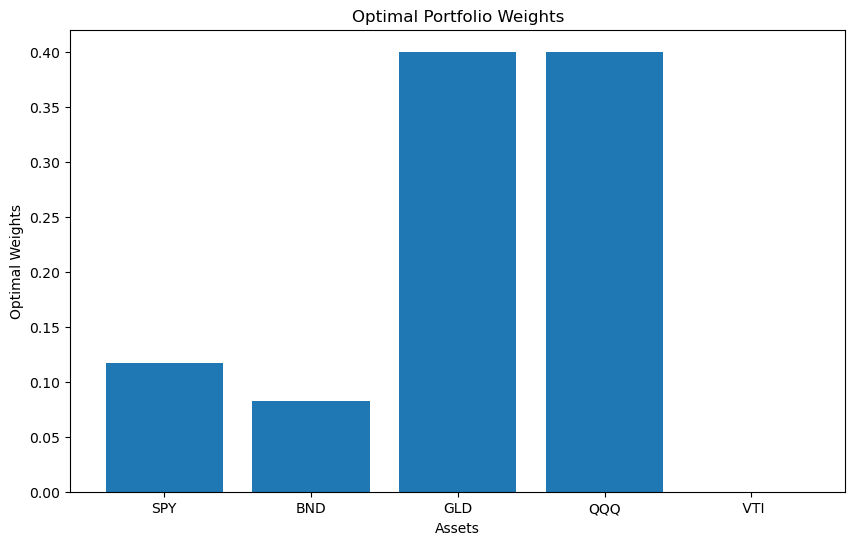

In [59]:
#creating bar chart pf optimal weights
plt.figure(figsize=(10,6))
plt.bar(tickers, optimal_weights)
#adding lables
plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')
#display the bar chart
plt.show()